# Project: Natural Language Processing with Disaster Tweets (https://www.kaggle.com/c/nlp-getting-started/overview)

### Brief description of the problem and data

- The dataset contains 7613 rows and five columns. The columns are:
     - id --> A unique number for every tweet.
     - text --> The actual text of the tweets
     - location --> The location the tweet was sent from (contains some empty cells)
     - keyword --> A keyword from the tweet (contains some empty cells)
     - target --> whether the tweet was about a disaster or not

In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from collections import Counter
import re
import nltk
import html
nltk.download('punkt') 
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer

from nltk import wsd
import numpy as np
from nltk.stem import WordNetLemmatizer
#from spacy.cli import download
#from spacy import load
import warnings

from nltk.tokenize import word_tokenize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import tensorflow as tf
from tensorflow.keras import models
from numpy import array_equal
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector

from keras.layers import SimpleRNN, BatchNormalization, Dense, Embedding


pd.set_option('display.max_colwidth', 120)

In [3]:
train = pd.read_csv('train.csv', encoding='utf-8')
test = pd.read_csv('test.csv', encoding='utf-8')

In [4]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [6]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place or...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


The first rows have no values for keyword and location. Location is even missing for ~33% of the rows.
--> **because of the missing values I will ignore the columns 'keyword' and 'location'**.

In [7]:
train[(train['keyword'].notnull()) & (train['location'].notnull())].head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N,0


We are not going to use the keyword and location column for our models but we can have a closer look at the content nonetheless.

In [8]:
train['keyword'].value_counts()

keyword
fatalities               45
deluge                   42
armageddon               42
damage                   41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [9]:
len(train['keyword'].unique())

222

In [10]:
train['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

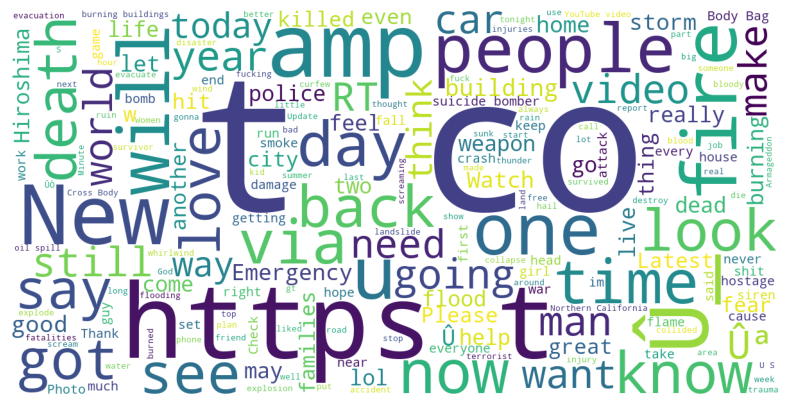

In [11]:
text = " ".join(train['text'])
wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off') 
plt.show()

- The abbreviation 'u' is often used in tweets instead of 'you'. Since 'you' is a stop word we should also add 'u' as a stop word.
- There are lots of weird 'words', like the u with a hat or 'https' or 't'.

In [12]:
stop_words = set(stopwords.words('english'))
stop_words.add('u')
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [13]:
def preprocess_text(text):
    text = text.lower()
    text = html.unescape(text) # &amp
    text = re.sub(r'http\S+', '', text)  # URLs
    text = re.sub(r'[^a-zA-Z]', ' ', text)  #Remove everything that is not a character...not 100% convinced it is good idea
    tokens = word_tokenize(text) #Return a tokenized copy of text, an improved TreebankWordTokenizer along with PunktSentenceTokenizer
    tokens = [w for w in tokens if not w in stop_words]
    lemmatizer = WordNetLemmatizer() #e.g. replaces 'dogs' with 'dog' 
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

In [14]:
train['ctext'] = train['text'].apply(preprocess_text) #ctext means cleaned text...

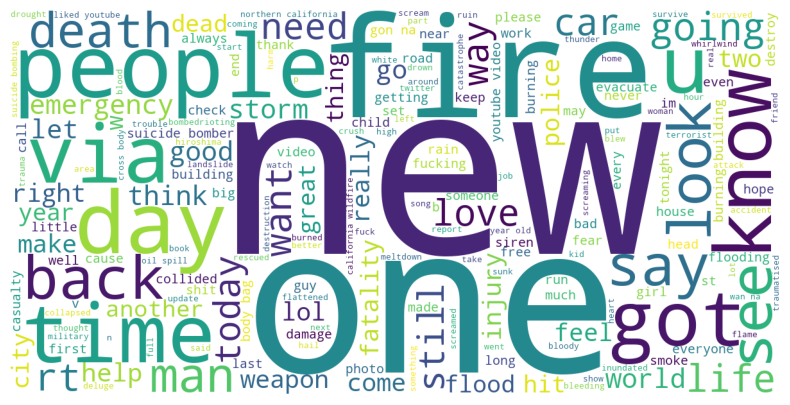

In [15]:
text = " ".join(train['ctext'])

wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Now the word cloud looks reasonable.

In [16]:
train[['text', 'target']].sample(30, random_state=42)

,text,target
2644,So you have a new weapon that can cause un-imaginable destruction.,1
2227,The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@,0
5448,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/v...,1
132,Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.,0
6845,in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3,0
5559,@Calum5SOS you look like you got caught in a rainstorm this is amazing and disgusting at the same time,0
1765,my favorite lady came to our volunteer meeting\nhopefully joining her youth collision and i am excite http://t.co/Ij...,1
1817,@brianroemmele UX fail of EMV - people want to insert and remove quickly like a gas pump stripe reader. 1 person tol...,1
6810,Can't find my ariana grande shirt this is a fucking tragedy,0
4398,The Murderous Story Of AmericaÛªs First Hijacking http://t.co/EYUGk6byxr,1


In [17]:
train[['ctext', 'target']].sample(30, random_state=42)

,ctext,target
2644,new weapon cause un imaginable destruction,1
2227,f ing thing gishwhes got soaked deluge going pad tampon thx mishacollins,0
5448,dt georgegalloway rt galloway mayor col police catch pickpocket liverpool stree,1
132,aftershock back school kick great want thank everyone making possible great night,0
6845,response trauma child addict develop defensive self one decrease vulnerability,0
5559,calum so look like got caught rainstorm amazing disgusting time,0
1765,favorite lady came volunteer meeting hopefully joining youth collision excite,1
1817,brianroemmele ux fail emv people want insert remove quickly like gas pump stripe reader person told crashed po,1
6810,find ariana grande shirt fucking tragedy,0
4398,murderous story america first hijacking,1


The comparison between the text and the cleaned text shows a world of difference. As a human being it is not always trivial to cluster the cleaned text into 'disaster' and 'no disaster'. For a simple deep learning without understanding of text it seems to be even harder.

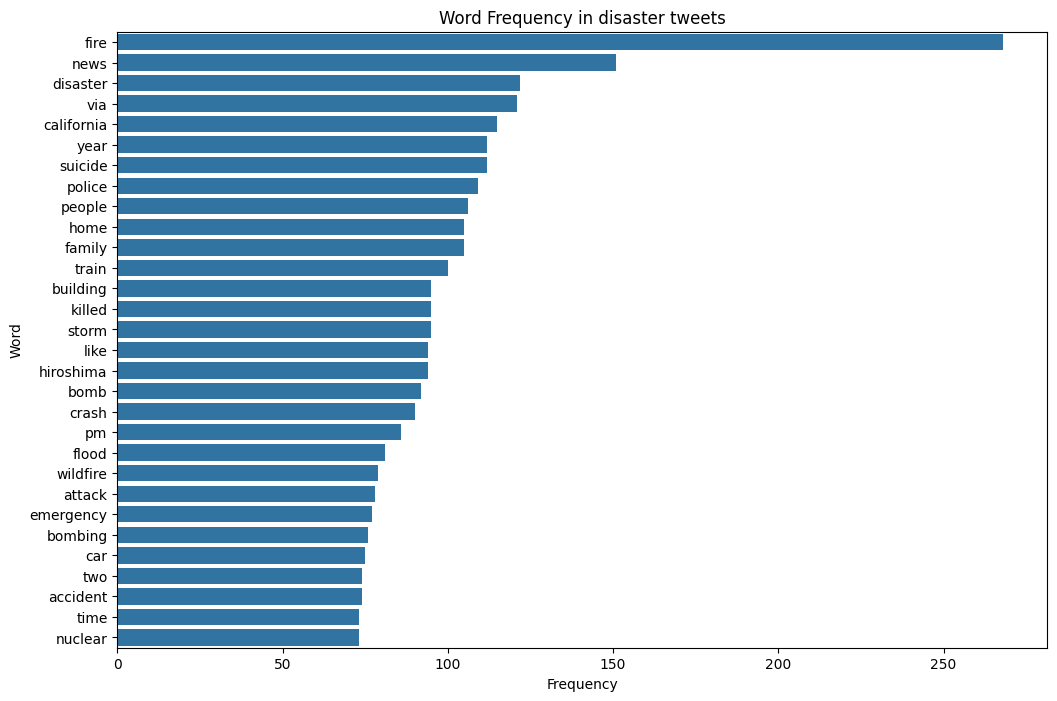

In [18]:
target1Data = train[train['target'] == 1]
all_text = ' '.join(target1Data['ctext'])  
words = re.findall(r'\w+', all_text.lower())  
word_counts = Counter(words)  
most_common_words = word_counts.most_common(30)  

df = pd.DataFrame(most_common_words, columns=['word', 'frequency'])  
plt.figure(figsize=(12, 8))  
sns.barplot(x='frequency', y='word', data=df)  
plt.xlabel('Frequency')  
plt.ylabel('Word')  
plt.title('Word Frequency in disaster tweets')  
plt.show()

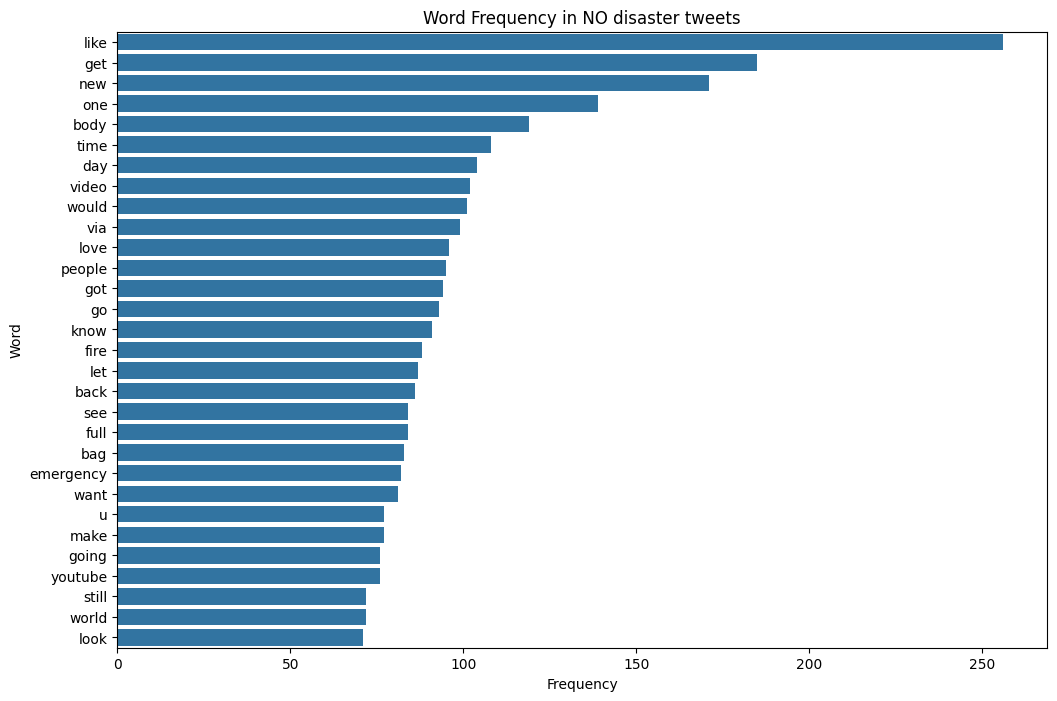

In [19]:
target0Data = train[train['target'] == 0]
all_text = ' '.join(target0Data['ctext'])  
words = re.findall(r'\w+', all_text.lower())  
word_counts = Counter(words)  
most_common_words = word_counts.most_common(30)  

df = pd.DataFrame(most_common_words, columns=['word', 'frequency'])  
plt.figure(figsize=(12, 8))  
sns.barplot(x='frequency', y='word', data=df)  
plt.xlabel('Frequency')  
plt.ylabel('Word')  
plt.title('Word Frequency in NO disaster tweets')  
plt.show()

### Model Architecture

We did not learn about natural language processing in 'CSCA 5642: Introduction to Deep Learning' but we already had an NLP task in the previous course 'CSCA 5632: Unsupervised Algorithms in Machine Learning' (BBC news). 

Since 'TF-IDF' (Term Frequency-Inverse Document Frequency) worked very well in the 'BBC news' project I am going to use it for this project again. TF-IDF is a statistical measure used to evaluate the importance of a word in a document relative to a corpus. It is an advanced method in comparison to simply counting the frequency of words. Since this is not a course about NLP I did not want to use any even more advanced methods. (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

I am going to try several RNN models and I have special interest in the most simple model that performs well.
The following layers will be used:
- RRN: Neural networks designed to handle sequential data by maintaining a hidden state that captures information about previous inputs.
- LSTM: A type of RNN that enhances the standard RNN's capability to remember information.
- BatchNormalization: A technique to standardize the inputs of each layer by scaling them.
- Dropout: A regularization method used during training to prevent overfitting.
- Dense: A neural network layer where each neuron is connected to every neuron in the previous layer. It is for example used in the output layer.


In [20]:
y = train['target'].astype(float)

tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 1))
X_tfidf = tfidf_vectorizer.fit_transform(train['ctext']).toarray()

X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_rnn = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [21]:
log_reg = LogisticRegression()
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
log_reg_best = grid_search.best_estimator_
y_pred = log_reg_best.predict(X_val)

In [22]:
print("Best Logistic Regression Model:", grid_search.best_params_)
print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report for Logistic Regression:")
print(classification_report(y_val, y_pred))

Best Logistic Regression Model: {'C': 1}
Logistic Regression Accuracy: 0.788575180564675
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.79      0.85      0.82       874
         1.0       0.78      0.70      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



Logistic regression acts as a benchmark for the deep learning models.

In [23]:
from keras.optimizers import Adam
def CreateSimpleRNN():
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=(1, X_train.shape[1]), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    adam = Adam(learning_rate = 0.0005)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model
model = CreateSimpleRNN()
model.summary()

C:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 128)                 │         144,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 144,641 (565.00 KB)

 Trainable params: 144,641 (565.00 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(X_train_rnn, y_train, epochs=10, batch_size=256, validation_data=(X_val_rnn, y_val), verbose=2)

Epoch 1/10
24/24 - 1s - 53ms/step - accuracy: 0.5951 - loss: 0.6825 - val_accuracy: 0.6054 - val_loss: 0.6707
Epoch 2/10
24/24 - 0s - 6ms/step - accuracy: 0.6305 - loss: 0.6564 - val_accuracy: 0.6559 - val_loss: 0.6457
Epoch 3/10
24/24 - 0s - 6ms/step - accuracy: 0.6892 - loss: 0.6235 - val_accuracy: 0.7223 - val_loss: 0.6137
Epoch 4/10
24/24 - 0s - 6ms/step - accuracy: 0.7534 - loss: 0.5821 - val_accuracy: 0.7649 - val_loss: 0.5760
Epoch 5/10
24/24 - 0s - 7ms/step - accuracy: 0.7993 - loss: 0.5361 - val_accuracy: 0.7840 - val_loss: 0.5393
Epoch 6/10
24/24 - 0s - 8ms/step - accuracy: 0.8172 - loss: 0.4935 - val_accuracy: 0.7794 - val_loss: 0.5112
Epoch 7/10
24/24 - 0s - 7ms/step - accuracy: 0.8210 - loss: 0.4599 - val_accuracy: 0.7814 - val_loss: 0.4917
Epoch 8/10
24/24 - 0s - 8ms/step - accuracy: 0.8251 - loss: 0.4346 - val_accuracy: 0.7787 - val_loss: 0.4804
Epoch 9/10
24/24 - 0s - 7ms/step - accuracy: 0.8287 - loss: 0.4163 - val_accuracy: 0.7820 - val_loss: 0.4734
Epoch 10/10
24/24 

Best accuracy:  0.7839789986610413


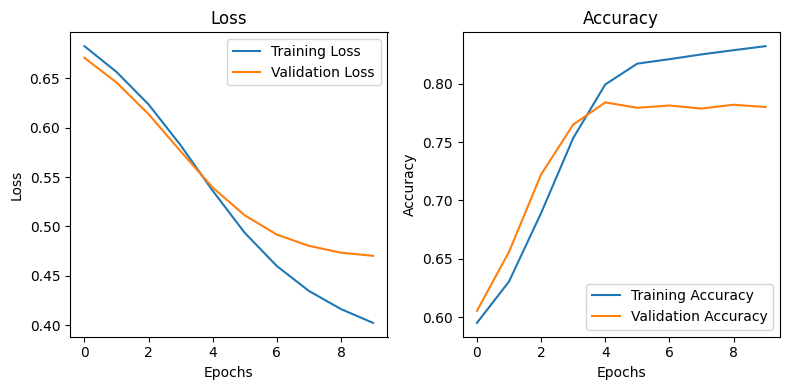

In [25]:
def PlotHistory(history):
    print("Best accuracy: ", max(history.history['val_accuracy']))
    
    plt.figure(figsize=(8, 4))  
    plt.subplot(1, 2, 1)  
    plt.plot(history.history['loss'], label='Training Loss')  
    plt.plot(history.history['val_loss'], label='Validation Loss')  
    plt.title('Loss')  
    plt.xlabel('Epochs')  
    plt.ylabel('Loss')  
    plt.legend()  
      
    if 'accuracy' in history.history:  
        plt.subplot(1, 2, 2)  
        plt.plot(history.history['accuracy'], label='Training Accuracy')  
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  
        plt.title('Accuracy')  
        plt.xlabel('Epochs')  
        plt.ylabel('Accuracy')  
        plt.legend()  
      
    plt.tight_layout()  
    plt.show()  
PlotHistory(history)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


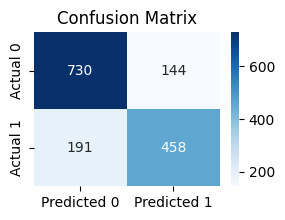

In [26]:
def PrintConfusionMatrix(model, X_val_rnn, y_val):
    y_pred = (model.predict(X_val_rnn) > 0.5).astype('int32')
    cm = confusion_matrix(y_val, y_pred)
    
    plt.figure(figsize=(3, 2))  
    plt.title('Confusion Matrix')  
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.show()  
PrintConfusionMatrix(model, X_val_rnn, y_val )    

### Model building an parameter tuning

#### Variation of number of features of the TfidfVectorizer

*****100 Features *****


C:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best accuracy:  0.7235718965530396


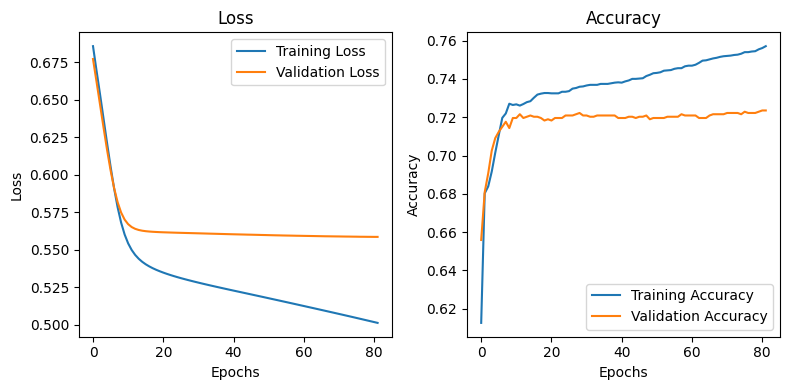

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


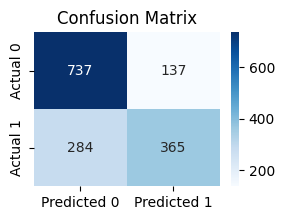

*****1000 Features *****


C:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best accuracy:  0.7833223938941956


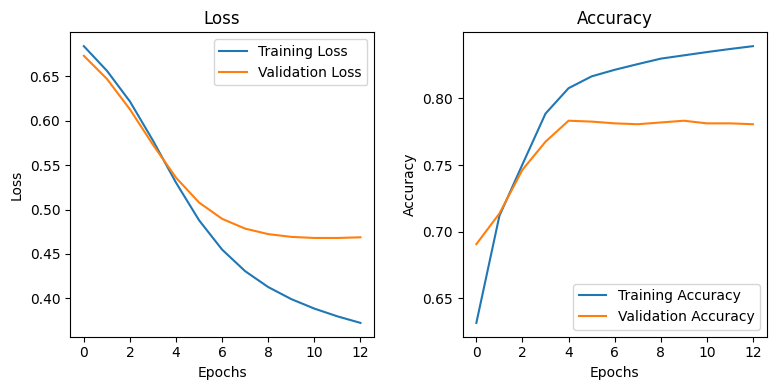

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


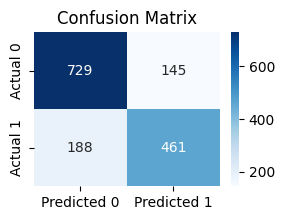

*****10000 Features *****


C:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best accuracy:  0.7984241843223572


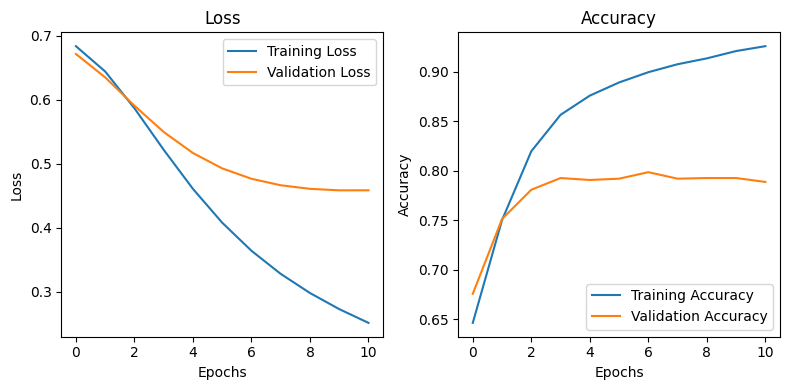

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


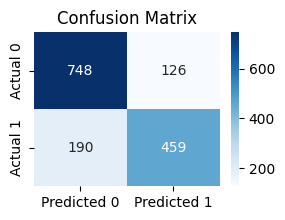

*****20000 Features *****


C:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best accuracy:  0.7977675795555115


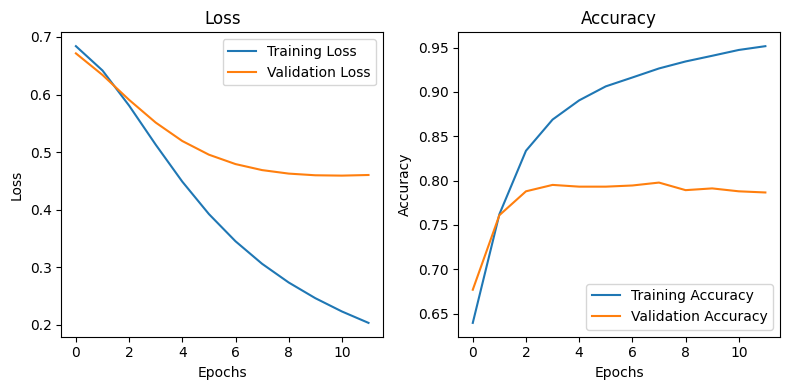

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


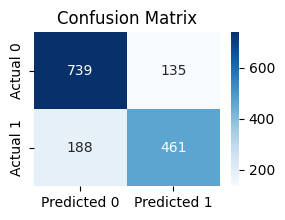

In [27]:
import random  
features = [100,1000,10000, 20000]
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

for featureTest in features:
    random.seed(42)  
    np.random.seed(42)  
    tf.random.set_seed(42)  
    print(f"*****{featureTest} Features *****")

    
    tfidf_vectorizer = TfidfVectorizer(max_features=featureTest, ngram_range=(1, 1))
    X_tfidf = tfidf_vectorizer.fit_transform(train['ctext']).toarray()
    
    X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
    
    X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val_rnn = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

    model = CreateSimpleRNN()

    history = model.fit(X_train_rnn, y_train, epochs=100, batch_size=256, validation_data=(X_val_rnn, y_val), verbose=0, callbacks=[early_stopping])
    PlotHistory(history)
    PrintConfusionMatrix(model, X_val_rnn, y_val )

In [28]:
def GetSimpleLSTM(units):
    model = Sequential([
        #Embedding(input_dim=10000, output_dim=64),
        LSTM(units),
        #BatchNormalization(),
        Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
        ])
    adam = Adam(learning_rate = 0.0005)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [29]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 1))
X_tfidf = tfidf_vectorizer.fit_transform(train['ctext']).toarray()

X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_rnn = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))



******16 units*****
Best accuracy:  0.7951411604881287


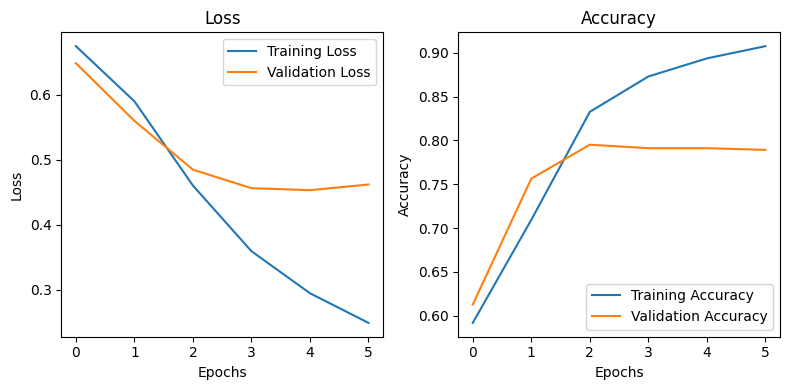

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


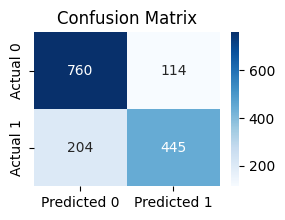

******64 units*****
Best accuracy:  0.7925148010253906


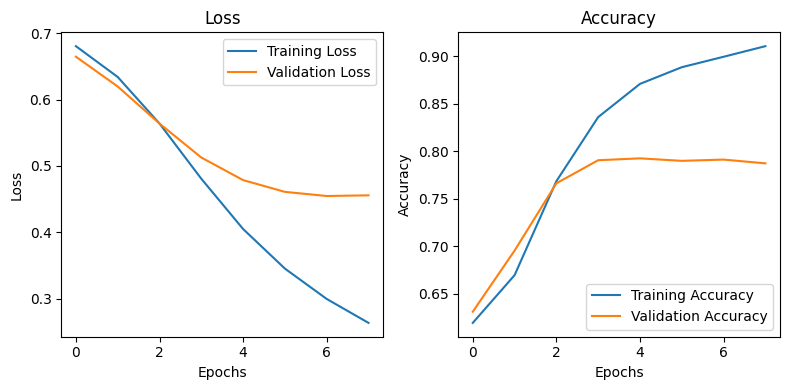

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


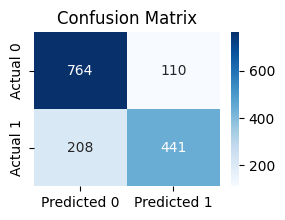

******128 units*****
Best accuracy:  0.7925148010253906


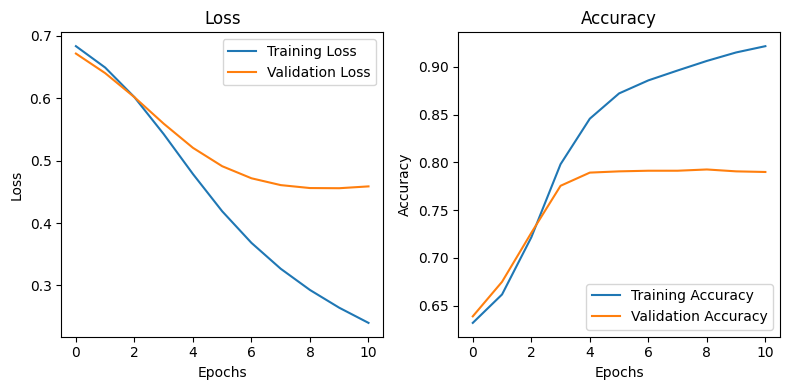

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


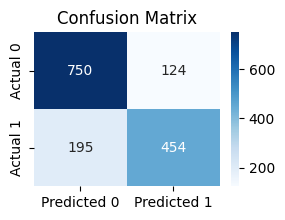

In [30]:
unitTests = [16,64,128]
for units in unitTests:
    print(f"******{units} units*****")
    model = GetSimpleLSTM(units)
    history = model.fit(X_train_rnn, y_train, epochs=100, batch_size=units, validation_data=(X_val_rnn, y_val), verbose=0, callbacks=[early_stopping])
    PlotHistory(history)
    PrintConfusionMatrix(model, X_val_rnn, y_val )

From this point on we cannot use 'TfidfVectorizer' because it is not compatible with the 'Embedding' layer. So we will switch to the keras 'Tokenizer'.

In [31]:
from keras.models import Sequential  
from keras.layers import Embedding, LSTM, BatchNormalization, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer  
from keras.utils import pad_sequences  
from sklearn.model_selection import train_test_split  

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tokenizer = Tokenizer(num_words=10000)  
tokenizer.fit_on_texts(train['ctext'])  

max_sequence_length = 50

sequences = tokenizer.texts_to_sequences(train['ctext']) 
X = pad_sequences(sequences, maxlen=max_sequence_length)  
y = train['target'].values 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)  

C:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Best accuracy:  0.7590282559394836


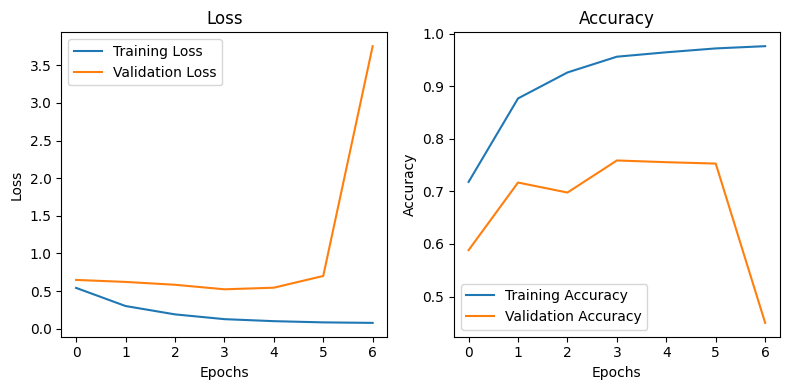

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


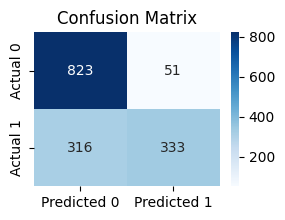

In [32]:
model = Sequential([  
    Embedding(input_dim=10000, output_dim=64, input_length=max_sequence_length),  
    LSTM(64),  
    BatchNormalization(),  
    Dense(1, activation='sigmoid')
])  
adam = Adam(learning_rate = 0.0005)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])  
  
history = model.fit(X_train, y_train, epochs=100, batch_size=64,  
                    validation_data=(X_val, y_val), verbose=0,  
                    callbacks=[early_stopping])  
  
PlotHistory(history)  
PrintConfusionMatrix(model, X_val, y_val)

C:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Best accuracy:  0.8049901723861694


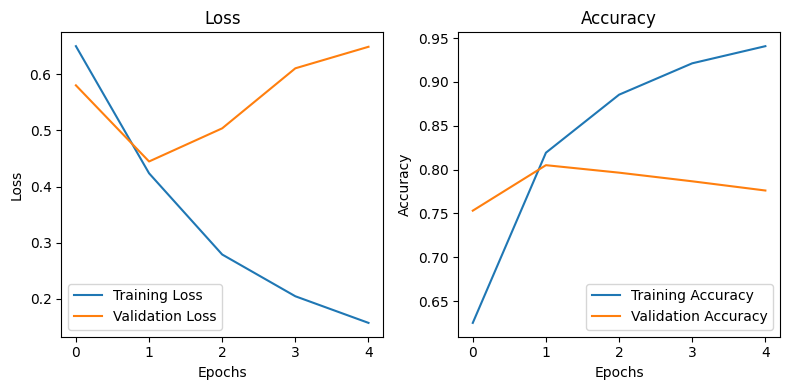

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


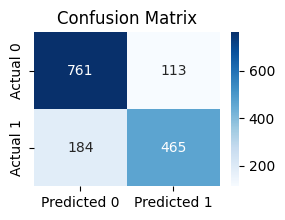

In [33]:
model = Sequential([  
    Embedding(input_dim=10000, output_dim=64, input_length=max_sequence_length),  
    LSTM(64),  
    Dense(1, activation='sigmoid')
])  
adam = Adam(learning_rate = 0.0005)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])  
  
history = model.fit(X_train, y_train, epochs=100, batch_size=64,  
                    validation_data=(X_val, y_val), verbose=0,  
                    callbacks=[early_stopping])  
  
PlotHistory(history)  
PrintConfusionMatrix(model, X_val, y_val)

C:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Best accuracy:  0.8043335676193237


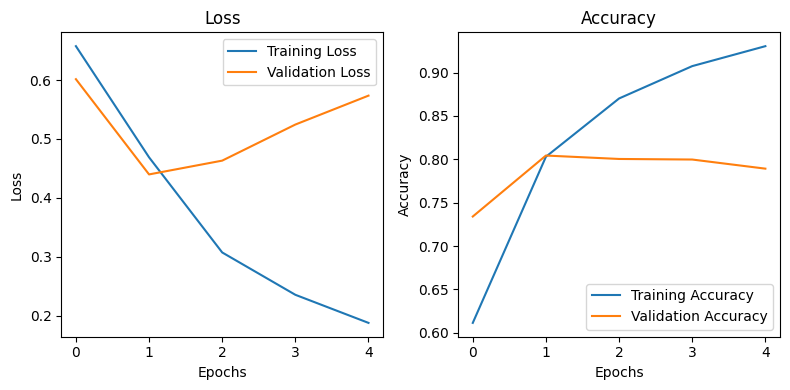

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


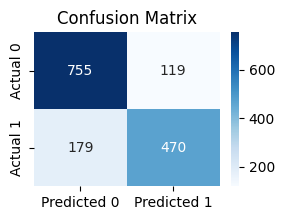

In [34]:
model = Sequential([  
    Embedding(input_dim=10000, output_dim=64, input_length=max_sequence_length),  
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),  
    Dense(1, activation='sigmoid')
])  
adam = Adam(learning_rate = 0.0005)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])  
  
history = model.fit(X_train, y_train, epochs=100, batch_size=64,  
                    validation_data=(X_val, y_val), verbose=0,  
                    callbacks=[early_stopping])  
  
PlotHistory(history)  
PrintConfusionMatrix(model, X_val, y_val)

C:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Best accuracy:  0.8017071485519409


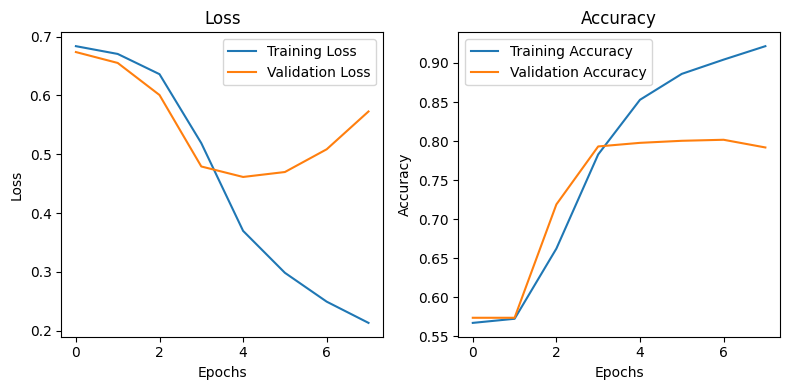

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


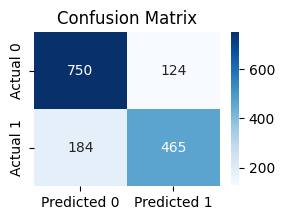

In [35]:
model = Sequential([  
    Embedding(input_dim=10000, output_dim=128, input_length=max_sequence_length),  
    Bidirectional(LSTM(128)),
    Dropout(0.4),
    Dense(64, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])  
adam = Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])  
  
history = model.fit(X_train, y_train, epochs=100, batch_size=64,  
                    validation_data=(X_val, y_val), verbose=0,  
                    callbacks=[early_stopping])  
  
PlotHistory(history)  
PrintConfusionMatrix(model, X_val, y_val)

In [36]:
# uncomment if a submission file is supposed to be created


#test['ctext'] = test['text'].apply(preprocess_text)
#sequences = tokenizer.texts_to_sequences(test['ctext']) 
#X = pad_sequences(sequences, maxlen=max_sequence_length)  

#predictions = model.predict(X)
#test['target'] = (predictions > 0.5).astype(int)

#submission = test[['id', 'target']]
#submission.to_csv(f"mysubmission.csv", index=False)

### Conclusion
#### Results
- Surprisingly nearly all my models had a similar accuracy on the validation test set of something between 0.78 and 0.805. Since there is some randomness in the initial weights every run shows slightly different results so it is not really possible to say which model performed best.
- I tried to following variations/model:
     - LogisticRegression: Is of course not a deep learning model but I added it as benchmark. Accuracy was ~0.78
     - TfidfVectorizer with different values for max_features. While 100 features (=words) were not enough for good performance, there was hardly any difference between 1000, 10000, 20000 features.
     - SimpleRNN was compared to LSTM and there was no significant difference between those models
     - An Embedding layer forced me to use the keras Tokenizer instead of the TfidfVectorizer
     - The number of units for LSTM had no influence of the performance
     - A BatchNormalization layer after the LSTM layer worsened the accuracy significantly
     - Accuracy of Embedding layer + LSTM was slightly higher than the one of LSTM and Tfid
     - Dropout did not have any significant impact on accuracy
     - One more complicated model was tested with bidrectional LSTM, two dropout and two dense layers. Accuracy was similar to the simpler model with only one LSTM layer
#### Improvements
- The developers leading the kaggle board (cheaters who have an accuracy of 1 aside) used pretrained models like Google's model BERT. I did not try those models because the task was to use RNN models.
- I feel the preprocessing of the texts could be done better. Removing the stop words removes context from the short tweets. If we have a look at the texts after preprocessing it looks like information was lost.